In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install numpy==1.24.4

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463300 sha256=51d78a23ccfdc18a4bc7780078acc87760ac1811002264bc4653defb56ea37b5
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from tqdm import tqdm
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split

In [4]:
ratings = pd.read_csv('/content/drive/My Drive/Datasets/ratings.csv')
movies  = pd.read_csv('/content/drive/My Drive/Datasets/movies.csv')

print(ratings.head())
print(movies.head())

   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [5]:
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
movies['metadata'] = movies['title'] + ' ' + movies['genres'].str.replace('|', ' ')

In [6]:
print("Ratings Count:")
print(ratings.count())
print("\nMovies Count:")
print(movies.count())

Ratings Count:
userId       25000095
movieId      25000095
rating       25000095
timestamp    25000095
dtype: int64

Movies Count:
movieId     62423
title       62423
genres      62423
metadata    62423
dtype: int64


In [7]:
active_users = ratings['userId'].value_counts()[ratings['userId'].value_counts() >= 100].index
popular_movies = ratings['movieId'].value_counts()[ratings['movieId'].value_counts() >= 200].index
filtered_ratings = ratings[
    ratings['userId'].isin(active_users) &
    ratings['movieId'].isin(popular_movies)
]

# Content-based setup with improved parameters
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies['metadata'].fillna(''))
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [8]:
movie_scores = {}
for idx in tqdm(range(len(movies)), desc="Precomputing content scores"):
    try:
        distances, indices = knn_model.kneighbors(tfidf_matrix[idx], n_neighbors=6)
        similarities = 1 - distances[0][1:]
        movie_scores[movies.iloc[idx]['movieId']] = np.mean(similarities)
    except:
        movie_scores[movies.iloc[idx]['movieId']] = 0.0

# Collaborative filtering setup with improved parameters
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(filtered_ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
svd_model = SVD(
    n_epochs=50,
    lr_all=0.008,
    reg_all=0.1,
    n_factors=150,
    random_state=42
)
svd_model.fit(trainset)

Precomputing content scores: 100%|██████████| 62423/62423 [09:25<00:00, 110.45it/s]


In [9]:
def hybrid_predict_batch(user_ids, movie_ids, svd_model, movie_scores_dict):
    testset = [[uid, mid, 0] for uid, mid in zip(user_ids, movie_ids)]
    svd_preds = svd_model.test(testset)
    svd_ests = np.array([pred.est for pred in svd_preds])

    content_scores = np.array([movie_scores_dict.get(mid, 0.0) for mid in movie_ids])

    svd_scaler = MinMaxScaler()
    content_scaler = MinMaxScaler()

    svd_norm = svd_scaler.fit_transform(svd_ests.reshape(-1, 1)).flatten()
    content_norm = content_scaler.fit_transform(content_scores.reshape(-1, 1)).flatten()

    hybrid_scores = 0.85 * svd_norm + 0.15 * content_norm

    return hybrid_scores * 4.5 + 0.5

In [10]:
ratings_train, ratings_test = train_test_split(
    filtered_ratings,
    test_size=0.2,
    random_state=42,
    stratify=filtered_ratings['userId']
)
ratings_test = ratings_test.reset_index(drop=True)

y_true = ratings_test['rating'].values
y_pred = hybrid_predict_batch(
    ratings_test['userId'].values,
    ratings_test['movieId'].values,
    svd_model,
    movie_scores
)

In [11]:
mse = mean_squared_error(y_true, y_pred)
rmse_val = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
print(f"Hybrid Model Error Metrics → MSE: {mse:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae:.4f}")

Hybrid Model Error Metrics → MSE: 0.6810, RMSE: 0.8253, MAE: 0.6384


In [12]:
threshold = np.percentile(y_true, 70)
y_true_b = (y_true >= threshold).astype(int)
y_pred_b = (y_pred >= threshold).astype(int)
y_score = y_pred

precision = precision_score(y_true_b, y_pred_b, zero_division=0)
recall = recall_score(y_true_b, y_pred_b, zero_division=0)
f1 = f1_score(y_true_b, y_pred_b, zero_division=0)
auc = roc_auc_score(y_true_b, y_score)

print("\nHybrid Model Classification Metrics:")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-Score:  {f1:.4f}")
print(f" AUC-ROC:   {auc:.4f}")


Hybrid Model Classification Metrics:
 Precision: 0.8684
 Recall:    0.2693
 F1-Score:  0.4112
 AUC-ROC:   0.8050


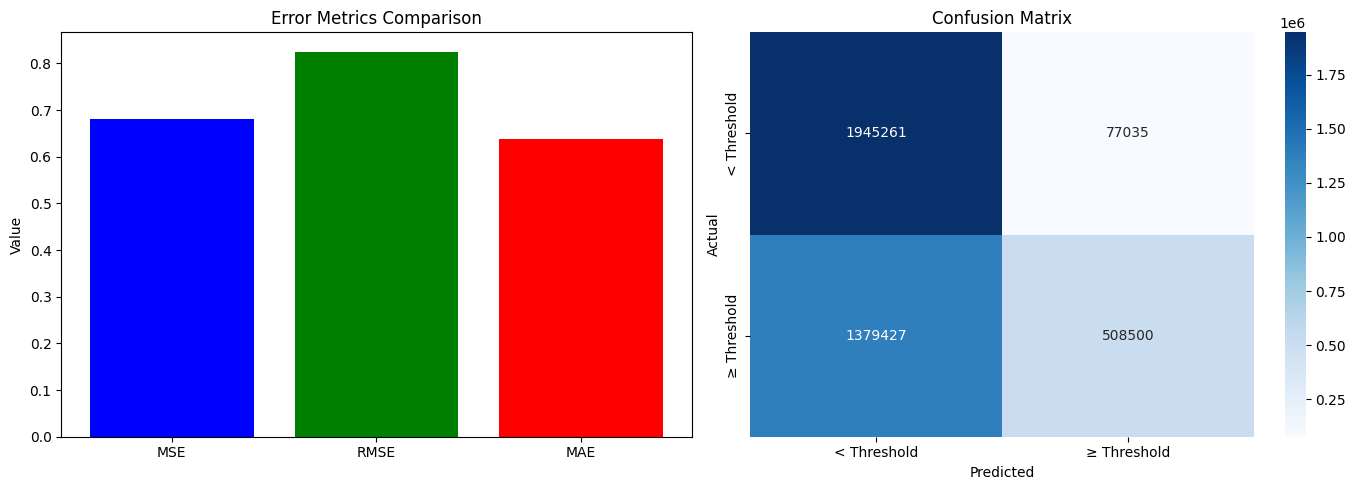

In [20]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Error metrics
ax[0].bar(['MSE', 'RMSE', 'MAE'], [mse, rmse_val, mae], color=['blue', 'green', 'red'])
ax[0].set_title('Error Metrics Comparison')
ax[0].set_ylabel('Value')

cm = confusion_matrix(y_true_b, y_pred_b)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_xticklabels(['< Threshold', '≥ Threshold'])
ax[1].set_yticklabels(['< Threshold', '≥ Threshold'])

plt.tight_layout()
plt.show()

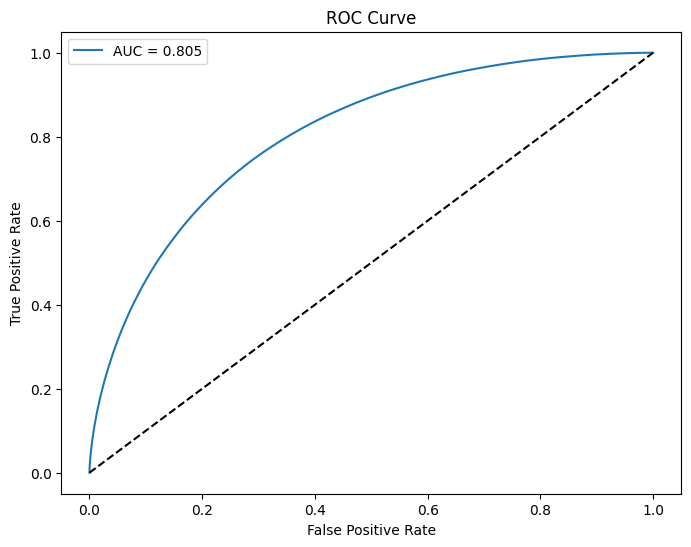

In [15]:
fpr, tpr, _ = roc_curve(y_true_b, y_score)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [16]:
def get_collaborative_recommendations(user_id, model, movies_df, n=10):
    all_movie_ids = movies_df['movieId'].unique()
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].unique()
    unrated_movies = list(set(all_movie_ids) - set(rated_movies))

    testset = [[user_id, movie_id, 0] for movie_id in unrated_movies]
    predictions = model.test(testset)

    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n*2]
    return pd.DataFrame({
        'movieId': [pred.iid for pred in top_predictions],
        'predicted_rating': [pred.est for pred in top_predictions]
    })

In [17]:
def get_content_recommendations(movie_title, tfidf_matrix, movies_df, n=10):
    movie_idx = movies_df.index[movies_df['title'] == movie_title].tolist()
    if not movie_idx:
        return pd.DataFrame()
    movie_idx = movie_idx[0]

    cosine_sim = cosine_similarity(tfidf_matrix[movie_idx], tfidf_matrix).flatten()
    top_indices = cosine_sim.argsort()[-n-1:-1][::-1]

    return pd.DataFrame({
        'movieId': movies_df.iloc[top_indices]['movieId'].values,
        'similarity_score': cosine_sim[top_indices]
    })

In [18]:
def hybrid_recommendations(user_id, movie_title, svd_model, tfidf_matrix, movies_df, n=10):

    collab_recs = get_collaborative_recommendations(user_id, svd_model, movies_df, n*2)
    content_recs = get_content_recommendations(movie_title, tfidf_matrix, movies_df, n*2)

    if collab_recs.empty and content_recs.empty:
        return pd.DataFrame()

    collab_min = collab_recs['predicted_rating'].min() if not collab_recs.empty else 0
    collab_max = collab_recs['predicted_rating'].max() if not collab_recs.empty else 1
    content_min = content_recs['similarity_score'].min() if not content_recs.empty else 0
    content_max = content_recs['similarity_score'].max() if not content_recs.empty else 1


    all_movies = set(collab_recs['movieId']).union(set(content_recs['movieId']))
    hybrid_df = pd.DataFrame({'movieId': list(all_movies)})

    hybrid_df = pd.merge(hybrid_df, collab_recs, on='movieId', how='left')
    hybrid_df = pd.merge(hybrid_df, content_recs, on='movieId', how='left')


    hybrid_df['predicted_rating_norm'] = (hybrid_df['predicted_rating'] - collab_min) / (collab_max - collab_min + 1e-10)
    hybrid_df['similarity_score_norm'] = (hybrid_df['similarity_score'] - content_min) / (content_max - content_min + 1e-10)


    hybrid_df.fillna(0, inplace=True)
    hybrid_df['hybrid_score'] = 0.5 * hybrid_df['predicted_rating_norm'] + 0.5 * hybrid_df['similarity_score_norm']

    top_hybrid = hybrid_df.sort_values('hybrid_score', ascending=False).head(n)
    top_hybrid = pd.merge(top_hybrid, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

    return top_hybrid[['movieId', 'title', 'genres', 'hybrid_score', 'predicted_rating', 'similarity_score']]

In [19]:
recommendations = hybrid_recommendations(
    user_id=1,
    movie_title='Iron Man',
    svd_model=svd_model, # Now this is the surprise SVD model
    tfidf_matrix=tfidf_matrix,
    movies_df=movies
)

print(recommendations)

   movieId                      title                                 genres  \
0   171011            Planet Earth II                            Documentary   
1    77561                 Iron Man 2  Action|Adventure|Sci-Fi|Thriller|IMAX   
2   159817               Planet Earth                            Documentary   
3   102125                 Iron Man 3            Action|Sci-Fi|Thriller|IMAX   
4      318  Shawshank Redemption, The                            Crime|Drama   
5   147070                   Iron Man                                  Drama   
6   167296                   Iron Man                                  Drama   
7   179135             Blue Planet II                            Documentary   
8   171495                     Cosmos                     (no genres listed)   
9   194228               The Iron Man                  Action|Comedy|Fantasy   

   hybrid_score  predicted_rating  similarity_score  
0      0.500000          4.373884          0.000000  
1      0.50